<h1><center> NeuroML-DB Electrophysiology Clustering Project </center></h1>

Requires Python 2.7 kernel.

<u>Objectives:</u>
1. Get notebook to run all cells [X]
2. Replace all cells with only cortical cells [X]
3. Refactor and make more apparent what is happening [ ]

In [3]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import pandas
from matplotlib import pyplot as plt
from os.path import join
import os
import requests
import string 
from scipy.stats import pearsonr
from scipy import stats
import statsmodels.formula.api as smf
import hdbscan
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', 20)

# There are Deprecation issues with python 2.7
# Don't print these
import warnings
warnings.filterwarnings('ignore')



In [14]:
# modules for PCA_and_Cluster
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np
from pprint import pprint as pp
from sklearn.cluster import AgglomerativeClustering

In [4]:
# input paths
cwd = os.getcwd()
path2data = join(cwd,'data')
path2figs = join(cwd,'figures')

print(path2data)
print(path2figs)

/Users/vrhaynes/Desktop/research/data_analysis/meta/LargeScaleModelAnalysis_2019/data
/Users/vrhaynes/Desktop/research/data_analysis/meta/LargeScaleModelAnalysis_2019/figures


### Original dataframes containing most NeuroML-DB cell models

In [3]:
# original files with ephys for all models 
# (USED TO GENERATE ONLY DATAFRAMES WITH CORTICAL CELLS)
raw_ephyz_file = join(path2data,'cell-ephyz-raw.csv')
transform_ephyz_file = join(path2data,'cell-ephyz-transformed.csv')

# contains all model IDs and model names in database 
# (NOTE THAT THERE ARE MORE CELLS WITH TAGS THAN INCLUDED ABOVE)
filename = join(path2models,'cell_tags.csv') 
cell_tags_df = pd.read_csv(filename,index_col=0)

# Read raw and bi-symmetric log transformed values
df_no_trans = pandas.read_csv(raw_ephyz_file)       # raw
df_all =      pandas.read_csv(transform_ephyz_file) # bi-symmetric

#Set index to be the model ID
df_no_trans.set_index('Unnamed: 0', inplace=True)
df_all.set_index('Unnamed: 0', inplace=True)
df_no_trans.index.name = df_all.index.name = "Cell_ID"

#create default cluster path
df_all["ClusterPath"] = "/"
df_all["Cluster"] = -1
df_all["WasNoise"] = False



### Updated dataframes containing only NeuroML-DB cortical cell models

<hr>

#### Code used to wrangle cortical cell models starts here 
(Not necessary to rerun notebook)


In [11]:
# returns list of cortical cell models and prints all cells that were either:
#     1. indeterminant (to be checked manually) or 
#     2. not a cortical cell model5
cortical_tags, non_cortical_tags = get_list_of_all_cortical_models(tags_df=cell_tags_df)



      Model_ID                Name
0  NMLCL000001  CA1 Pyramidal Cell
      Model_ID          Name
1  NMLCL000002  Granule Cell
      Model_ID                       Name
2  NMLCL000003  Granule Input Mossy Fiber
      Model_ID        Name
3  NMLCL000004  Golgi Cell
      Model_ID           Name
4  NMLCL000005  Purkinje Cell
      Model_ID        Name
6  NMLCL000085  Golgi Cell
      Model_ID                      Name
7  NMLCL000086  Izhikevich Tonic Spiking
         Model_ID                       Name
1043  NMLCL001122  Hippocampus Pyramidal CA3
         Model_ID               Name
1044  NMLCL001123  Fast Spiking (FS)
         Model_ID                         Name
1045  NMLCL001124  Intrinsically Bursting (IB)
         Model_ID                                     Name
1046  NMLCL001125  Intrinsically Repetitive Bursting (IBR)
         Model_ID                         Name
1047  NMLCL001126  Low Threshold Spiking (LTS)
         Model_ID                  Name
1048  NMLCL001127  Regular S

In [40]:
# add the cells that were manually checked to be cortical that don't have a neurolex ID/Keyword 
# (some do have keywords that specify if they are cortical but I don't check for that since there's
# such a small example of these)
# !-- NOTE: Not included is any cell that could be considered a general neuron model (For example, Izhikevich), 
# so check in with Sharon and Rick, not sure if this appropriate
# !-- NOTE: There's ONE Pospischil model (LTS) labeled as thalamus but could be error (it's a minimal model), one falsely excluded sample not a huge deal though
other_cortical_cells = ['NMLCL001650', # Dura-Bernal, M1 - CT -> (says in model name)
                        'NMLCL001657', # Dura-Bernal, M1 - SOM -> (says in model name)
                        'NMLCL001660', # Dura-Bernal, M1 - PT -> (says in model name)
                        'NMLCL001663', # Dura-Bernal, M1 - IT -> (says in model name)
                        'NMLCL001664', # Dura-Bernal, M1 - PV -> (says in model name)
                        'NMLCL001123', # Pospischil, neocortex - FS -> (says in keywords)
                        'NMLCL001124', # Pospischil, neocortex - IB -> (says in keywords)
                        'NMLCL001125', # Pospischil, neocortex - IRB -> (says in keywords)
                        'NMLCL001127', # Pospischil, neocortex - RS -> (says in keywords)
                        'NMLCL001134', # Traub, A1 - Deep Axoaxonic FS (chandelier) -> (says in paper) 
                        'NMLCL001136', # Traub, A1 - Deep LTS -> (says in paper)
                        'NMLCL001139', # Traub, A1 - L4 RS spiny stellate -> (says in paper)
                        'NMLCL001140', # Traub, A1 - L5 IB pyramid -> (says in paper)
                        'NMLCL001141', # Traub, A1 - L5 RS pyramid -> (says in paper)
                        'NMLCL001142', # Traub, A1 - L6 RS pyramid -> (says in paper)
                        'NMLCL001143', # Traub, A1 - Superficial Axoaxonic FS (chandelier) -> (says in paper)
                        'NMLCL001145'] # Traub, A1 - Superficial LTS -> (says in paper)
                        


In [47]:
a = cortical_tags
b = other_cortical_cells

set(a).intersection(b) # check if accidentally duplicated some



set()

In [48]:
final_cortical_tags = cortical_tags + other_cortical_cells

print('Total number of cortical cells = %s' %len(final_cortical_tags))



Total number of cortical cells = 1156


In [49]:
# save these
cortical_cell_tags_df = cell_tags_df[cell_tags_df['Model_ID'].isin(final_cortical_tags)]
cortical_ephys_df = df_all.loc[final_cortical_tags]

filename = join(path2data,'cortical_tags.csv')
cortical_cell_tags_df.to_csv(filename)

filename = join(path2data,'cortical_ephys.csv')
cortical_ephys_df.to_csv(filename)

cortical_ephys_no_trans_df = df_no_trans.loc[cortical_ephys_df.index.values.tolist()]
filename = join(path2data,'cortical_ephys_no_trans.csv')
cortical_ephys_no_trans_df.to_csv(filename)

#### Code used to wrangle cortical cell models ends here 
<hr>

### Load data and cluster

In [5]:
# ONLY THESE ARE USED IN THE FOLLOWING ANALYSES
filename = join(path2data,'cortical_tags.csv')
cortical_tags_df = pd.read_csv(filename,index_col=0)  # updated version of cell_tags_df

filename = join(path2data,'cortical_ephys.csv')   
cortical_ephys_df = pd.read_csv(filename,index_col=0) # updated version of df_all

filename = join(path2data,'cortical_ephys_no_trans.csv')
cortical_ephys_no_trans_df = pd.read_csv(filename,index_col=0) # updated version of df_no_trans

# (NOT SURE WHERE THESE WERE OVERWRITTEN)
# !-- TODO: include in a data wrangling notebook if deemed necessary for transparency
# i.e. what is the point of entry for analysis pipeline??
cortical_ephys_df["ClusterPath"] = "/" # default cluster path
cortical_ephys_df["Cluster"] = -1      # default cluster assignment
cortical_ephys_df["WasNoise"] = False  # default cluster noise?



In [6]:
cortical_ephys_df.head()


,AP1Amplitude,AP2Amplitude,AP12AmplitudeDrop,AP12AmplitudeChangePercent,AP1SSAmplitudeChange,AP1WidthHalfHeight,AP2WidthHalfHeight,AP12HalfWidthChangePercent,AP1WidthPeakToTrough,AP2WidthPeakToTrough,AP1RateOfChangePeakToTrough,AP2RateOfChangePeakToTrough,AP12RateOfChangePeakToTroughPercentChange,AP1AHPDepth,AP2AHPDepth,AP12AHPDepthPercentChange,AP1DelayMean,AP2DelayMean,AP1DelaySD,AP2DelaySD,AP1DelayMeanStrongStim,AP2DelayMeanStrongStim,AP1DelaySDStrongStim,AP2DelaySDStrongStim,Burst1ISIMean,Burst1ISIMeanStrongStim,Burst1ISISD,Burst1ISISDStrongStim,InitialAccommodationMean,SSAccommodationMean,AccommodationRateToSS,AccommodationAtSSMean,AccommodationRateMeanAtSS,ISIMedian,ISICV,ISIBurstMeanChange,SpikeRateStrongStim,InputResistance,SteadyStateAPs,FrequencyPassAbove,FrequencyPassBelow,RampFirstSpike,ClusterPath,Cluster,WasNoise
Cell_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NMLCL000073,72.021610,72.400025,-0.626651,0.792911,2.471638,0.776715,0.776715,-5.018208e-14,2.064928,2.062003,-4.202512,-4.216059,1.432269,3.467849,3.504207,2.282398,4.015592,4.442360,0.0,0.0,2.858793,3.487577,0.0,0.0,3.621466,2.879697,0.000000e+00,0.0,-20.000000,-20.000000,-0.148431,-96.647898,5.177776,5.605389,2.108681,4.684226,3.663373,4.451864,0.0,4.423248,5.799909,8.478025,/,-1,False
NMLCL000087,84.288880,80.881247,2.180007,-2.333007,2.146752,0.699694,0.699694,0.000000e+00,2.216393,2.238730,-4.280392,-4.235274,-2.424852,4.093041,4.136403,2.431638,3.335820,4.890403,0.0,0.0,2.498772,4.211084,0.0,0.0,5.869616,4.135936,2.842171e-14,0.0,-33.333333,-33.333333,-0.215915,-82.601580,3.179130,6.400770,2.146764,6.994468,3.023930,7.855118,0.0,4.216193,4.974371,8.499853,/,-1,False
NMLCL000088,84.454780,81.181570,2.144391,-2.294968,2.209753,0.688191,0.699694,1.849218e+00,2.203764,2.221400,-4.299764,-4.252321,-2.469452,4.109631,4.116765,0.984342,3.314286,4.884152,0.0,0.0,2.479666,4.204918,0.0,0.0,5.877195,4.135015,2.842171e-14,0.0,-33.333333,-33.333333,-0.214654,-82.625645,3.179130,6.400062,2.146439,7.008366,3.023930,7.876273,0.0,4.216193,4.968629,8.499769,/,-1,False
NMLCL000089,83.838360,80.624230,2.128328,-2.285182,2.128490,0.688191,0.699694,1.849218e+00,2.231340,2.246066,-4.263670,-4.224130,-2.307988,4.109378,4.133597,1.907875,3.353686,4.895928,0.0,0.0,2.511931,4.215173,0.0,0.0,5.869843,4.138326,2.842171e-14,0.0,-33.333333,-33.333333,-0.215739,-82.606756,3.179130,6.402412,2.146682,6.991675,3.023930,7.849193,0.0,4.216193,4.864245,8.499961,/,-1,False
NMLCL000090,84.527707,80.747240,2.272625,-2.424645,2.225019,0.711067,0.699694,-1.811048e+00,2.172788,2.193545,-4.333766,-4.284414,-2.504325,4.105085,4.137885,2.175480,3.301648,4.886761,0.0,0.0,2.477735,4.203199,0.0,0.0,5.899088,4.138326,2.842171e-14,0.0,-33.333333,-33.333333,-0.210686,-82.707745,3.179130,6.409164,2.145146,7.030063,3.023930,7.885411,0.0,4.216193,4.954613,8.499741,/,-1,False


In [7]:
len(cortical_ephys_no_trans_df.index)

1156

In [8]:
cortical_ephys_no_trans_df.head()



,AP1Amplitude,AP2Amplitude,AP12AmplitudeDrop,AP12AmplitudeChangePercent,AP1SSAmplitudeChange,AP1WidthHalfHeight,AP2WidthHalfHeight,AP12HalfWidthChangePercent,AP1WidthPeakToTrough,AP2WidthPeakToTrough,AP1RateOfChangePeakToTrough,AP2RateOfChangePeakToTrough,AP12RateOfChangePeakToTroughPercentChange,AP1AHPDepth,AP2AHPDepth,AP12AHPDepthPercentChange,AP1DelayMean,AP2DelayMean,AP1DelaySD,AP2DelaySD,AP1DelayMeanStrongStim,AP2DelayMeanStrongStim,AP1DelaySDStrongStim,AP2DelaySDStrongStim,Burst1ISIMean,Burst1ISIMeanStrongStim,Burst1ISISD,Burst1ISISDStrongStim,InitialAccommodationMean,SSAccommodationMean,AccommodationRateToSS,AccommodationAtSSMean,AccommodationRateMeanAtSS,ISIMedian,ISICV,ISIBurstMeanChange,SpikeRateStrongStim,InputResistance,SteadyStateAPs,FrequencyPassAbove,FrequencyPassBelow,RampFirstSpike
Cell_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NMLCL000073,72.021610,72.400025,-0.378415,0.525418,4.708547,0.51,0.51,-2.176908e-14,2.99,2.98,-28.600047,-28.996047,1.384614,13.492530,14.008195,3.821857,23.65,36.47,0.0,0.0,7.14,13.77,0.0,0.0,15.805,7.300,0.000000e+00,0.0,-20.000000,-20.000000,-0.069493,-96.647898,76.560933,117.645,3.143150,46.567863,16.5,36.822394,0,35.771368,143.000000,2087.63
NMLCL000087,84.288880,80.881247,3.407633,-4.042803,3.281971,0.44,0.44,0.000000e+00,3.55,3.64,-30.951633,-29.567020,-4.473474,25.589417,26.742705,4.506893,11.77,57.33,0.0,0.0,4.85,28.85,0.0,0.0,153.355,26.730,2.842171e-14,0.0,-33.333333,-33.333333,-0.104664,-82.601580,10.000000,261.145,3.282016,473.200176,8.5,1119.567360,0,29.000000,62.389819,2133.71
NMLCL000088,84.454780,81.181570,3.273210,-3.875695,3.523634,0.43,0.44,2.325581e+00,3.50,3.57,-31.565582,-30.082846,-4.697318,26.024756,26.214190,0.727900,11.51,56.97,0.0,0.0,4.75,28.67,0.0,0.0,154.525,26.705,2.842171e-14,0.0,-33.333333,-33.333333,-0.103985,-82.625645,10.000000,260.960,3.280810,479.828421,8.5,1143.513263,0,29.000000,62.030110,2133.53
NMLCL000089,83.838360,80.624230,3.214130,-3.833722,3.214723,0.43,0.44,2.325581e+00,3.61,3.67,-30.431147,-29.234540,-3.932178,26.018081,26.666532,2.492310,11.99,57.65,0.0,0.0,4.92,28.97,0.0,0.0,153.390,26.795,2.842171e-14,0.0,-33.333333,-33.333333,-0.104569,-82.606756,10.000000,261.575,3.281712,471.879106,8.5,1112.951221,0,29.000000,55.838551,2133.94
NMLCL000090,84.527707,80.747240,3.780467,-4.472459,3.584518,0.45,0.44,-2.222222e+00,3.38,3.46,-32.672329,-31.078107,-4.879426,25.904764,26.783009,3.390283,11.36,57.12,0.0,0.0,4.74,28.62,0.0,0.0,157.955,26.795,2.842171e-14,0.0,-33.333333,-33.333333,-0.101853,-82.707745,10.000000,263.350,3.276009,490.362762,8.5,1154.015446,0,29.000000,61.160714,2133.47


In [9]:
prop_names = [
    'AP1Amplitude',
    'AP2Amplitude',
    'AP12AmplitudeDrop',
    'AP12AmplitudeChangePercent',
    'AP1SSAmplitudeChange',  
    
    'AP1WidthHalfHeight',
    'AP2WidthHalfHeight',
    'AP12HalfWidthChangePercent',
    
    'AP1WidthPeakToTrough',
    'AP2WidthPeakToTrough',
    
    'AP1RateOfChangePeakToTrough',
    'AP2RateOfChangePeakToTrough',    
    'AP12RateOfChangePeakToTroughPercentChange',
    
    'AP1AHPDepth',
    'AP2AHPDepth',
    'AP12AHPDepthPercentChange',
    
    'AP1DelayMean',
    'AP2DelayMean',
    
    'AP1DelaySD',
    'AP2DelaySD',
    
    'AP1DelayMeanStrongStim',
    'AP2DelayMeanStrongStim',
    
    'AP1DelaySDStrongStim',
    'AP2DelaySDStrongStim',
    
    'Burst1ISIMean',
    'Burst1ISIMeanStrongStim',
    
    'Burst1ISISD',
    'Burst1ISISDStrongStim',
    
    'InitialAccommodationMean',
    'SSAccommodationMean',
    'AccommodationRateToSS',
    'AccommodationAtSSMean',
    'AccommodationRateMeanAtSS',
    
    
    'ISIMedian',
    'ISICV',
    'ISIBurstMeanChange',
    
    'SpikeRateStrongStim',
    
    'InputResistance',
    
    'SteadyStateAPs',
    
    'FrequencyPassAbove',
    'FrequencyPassBelow',
    
    'RampFirstSpike',
]

Dimensions reduced from 42 to 21
Number of rows = 1156


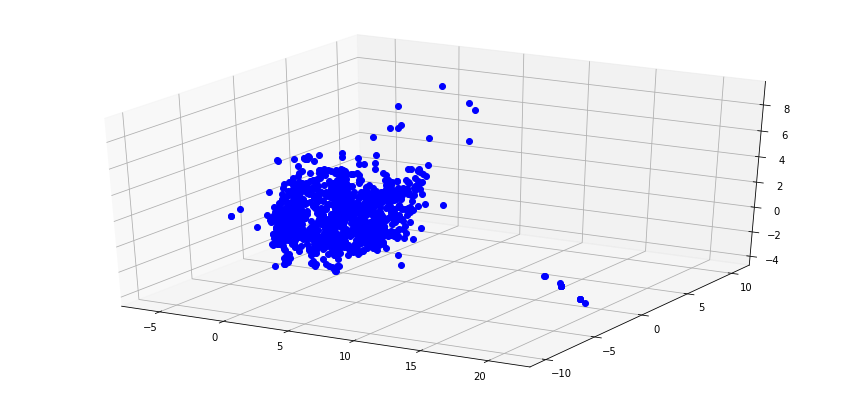

For n_clusters = 2, the average silhoette score is = 0.6963023743903991
For n_clusters = 3, the average silhoette score is = 0.19173728211097749
For n_clusters = 4, the average silhoette score is = 0.18650172319722863
For n_clusters = 5, the average silhoette score is = 0.20537390080062873
For n_clusters = 6, the average silhoette score is = 0.2167134597439695
For n_clusters = 7, the average silhoette score is = 0.21992200537583684


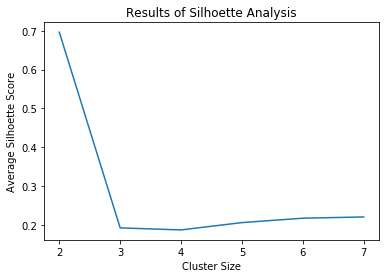

Positive vs Negative loadings with PC1 :
['AP2DelayMeanStrongStim' 'AP2DelayMean' 'Burst1ISIMeanStrongStim'
 'AP1DelayMeanStrongStim' 'Burst1ISIMean']
[0.91826524 0.89285319 0.85850153 0.8565413  0.84689291]
+ R for AP2DelayMeanStrongStim
+ R for AP2DelayMean
+ R for Burst1ISIMeanStrongStim

         -----            
Positive vs Negative loadings with PC2 :
['ISICV' 'InitialAccommodationMean' 'AccommodationAtSSMean'
 'SSAccommodationMean' 'AP1SSAmplitudeChange']
[ 0.72305816  0.7104553   0.71002091  0.68191728 -0.6723483 ]
+ R for ISICV
+ R for InitialAccommodationMean
+ R for AccommodationAtSSMean

         -----            
Positive vs Negative loadings with PC3 :
['AP2WidthPeakToTrough' 'AP1WidthPeakToTrough'
 'AP2RateOfChangePeakToTrough' 'AP1RateOfChangePeakToTrough'
 'AP12RateOfChangePeakToTroughPercentChange']
[ 0.68568941  0.67177121  0.55149419  0.48141306 -0.47504645]
+ R for AP2WidthPeakToTrough
+ R for AP1WidthPeakToTrough
+ R for AP2RateOfChangePeakToTrough

         ----

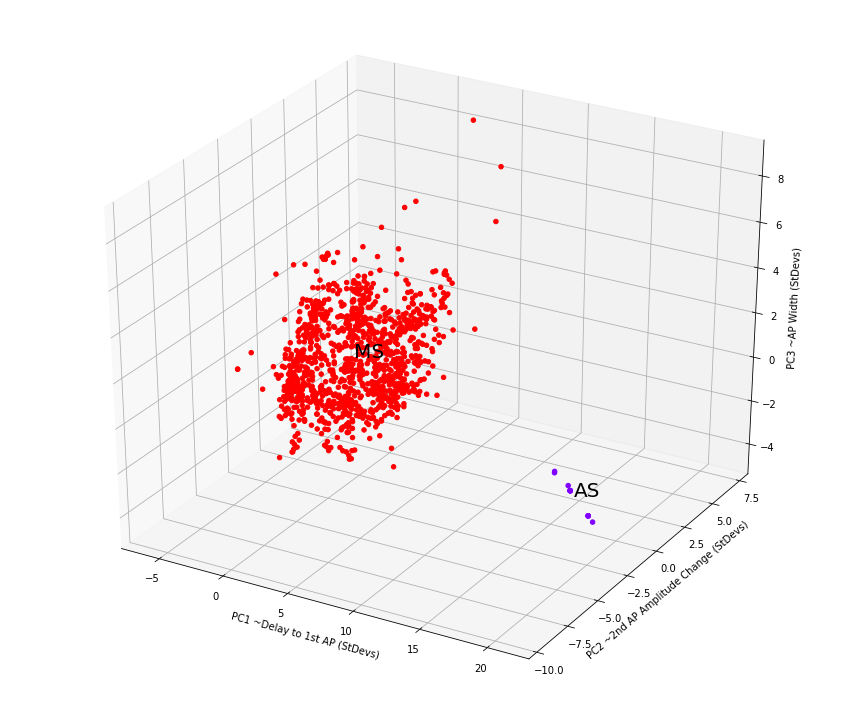

Number of members in each cluster assignment: Counter({1: 1132, 0: 15, -1: 9})
{'cells': Index([u'NMLCL001540', u'NMLCL001505', u'NMLCL001485', u'NMLCL001428',
       u'NMLCL001491'],
      dtype='object', name=u'Cell_ID'),
 'center': ['       19.30', '       -2.89', '       -2.22'],
 'cluster': 0,
 'sd': ['        1.15', '        0.30', '        0.41']}
{'cells': Index([u'NMLCL000355', u'NMLCL000392', u'NMLCL000372', u'NMLCL000395',
       u'NMLCL000277'],
      dtype='object', name=u'Cell_ID'),
 'center': ['       -0.30', '        0.04', '       -0.01'],
 'cluster': 1,
 'sd': ['        2.18', '        2.22', '        1.84']}
['ISIMedian', 'AccommodationAtSSMean', 'AP1DelayMeanStrongStim']
('reg isi v delay params p-s r', array([ 6.96851269e+01, -3.73760322e-02]), array([0.00695519, 0.0526738 ]), 0.356152365327274)
('reg accom v delay params p-s r', array([67.60898842,  0.63780398]), array([0.00456872, 0.03589627]), 0.4166079047347653)
('delay v accom', (0.6996655748591033, 0.03589626

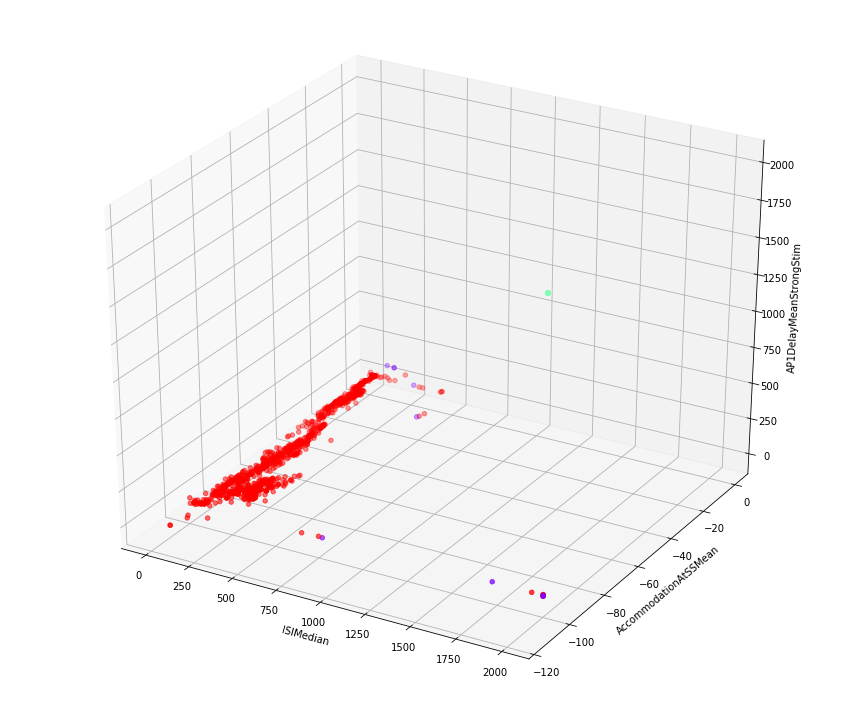

('current subset clusters', array(['/0/', '/1/'], dtype=object))
('all clusters', array(['/0/', '/1/'], dtype=object))


In [17]:
PCA_and_Cluster(samples_df = cortical_ephys_df,
                raw_samples_df = cortical_ephys_no_trans_df,
                parent_path = "/", 
                hide_noise = True, 
                remove_noise = False, 
                k_means = False, 
                interactive=False,
                cluster_captions=['AS','MS','RA','npRB'],
                axis_captions=['PC1 ~Delay to 1st AP (StDevs)', 'PC2 ~2nd AP Amplitude Change (StDevs)', 'PC3 ~AP Width (StDevs)'])

Dimensions reduced from 42 to 22
Number of rows = 1140


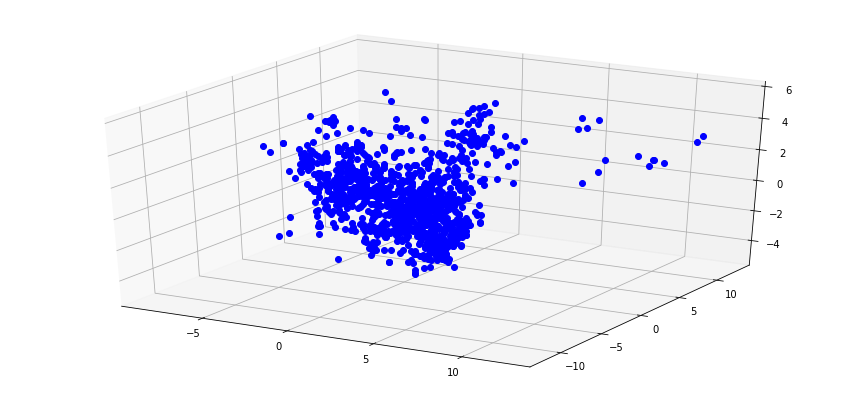

For n_clusters = 2, the average silhoette score is = 0.18903953507236185
For n_clusters = 3, the average silhoette score is = 0.19714839052167918
For n_clusters = 4, the average silhoette score is = 0.19061778096982807
For n_clusters = 5, the average silhoette score is = 0.2012550564848879
For n_clusters = 6, the average silhoette score is = 0.17870741998328266
For n_clusters = 7, the average silhoette score is = 0.17980884795655036


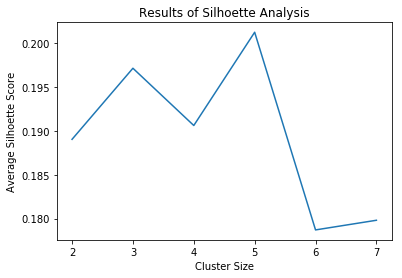

Positive vs Negative loadings with PC1 :
['AP2DelayMean' 'AP2DelayMeanStrongStim' 'AP1DelayMean'
 'AP1DelayMeanStrongStim' 'Burst1ISIMean']
[0.91189325 0.88032814 0.85011203 0.82771279 0.79724044]
+ R for AP2DelayMean
+ R for AP2DelayMeanStrongStim
+ R for AP1DelayMean

         -----            
Positive vs Negative loadings with PC2 :
['InitialAccommodationMean' 'SSAccommodationMean' 'ISICV'
 'AccommodationAtSSMean' 'AccommodationRateToSS']
[-0.80298753 -0.78032926 -0.77753211 -0.7443785  -0.7177566 ]
- R for InitialAccommodationMean
- R for SSAccommodationMean
- R for ISICV

         -----            
Positive vs Negative loadings with PC3 :
['AP2RateOfChangePeakToTrough' 'AP2WidthPeakToTrough'
 'AP1RateOfChangePeakToTrough' 'AP1WidthPeakToTrough'
 'AP12RateOfChangePeakToTroughPercentChange']
[ 0.62669741  0.56763758  0.56106442  0.53168044 -0.52863225]
+ R for AP2RateOfChangePeakToTrough
+ R for AP2WidthPeakToTrough
+ R for AP1RateOfChangePeakToTrough

         -----            


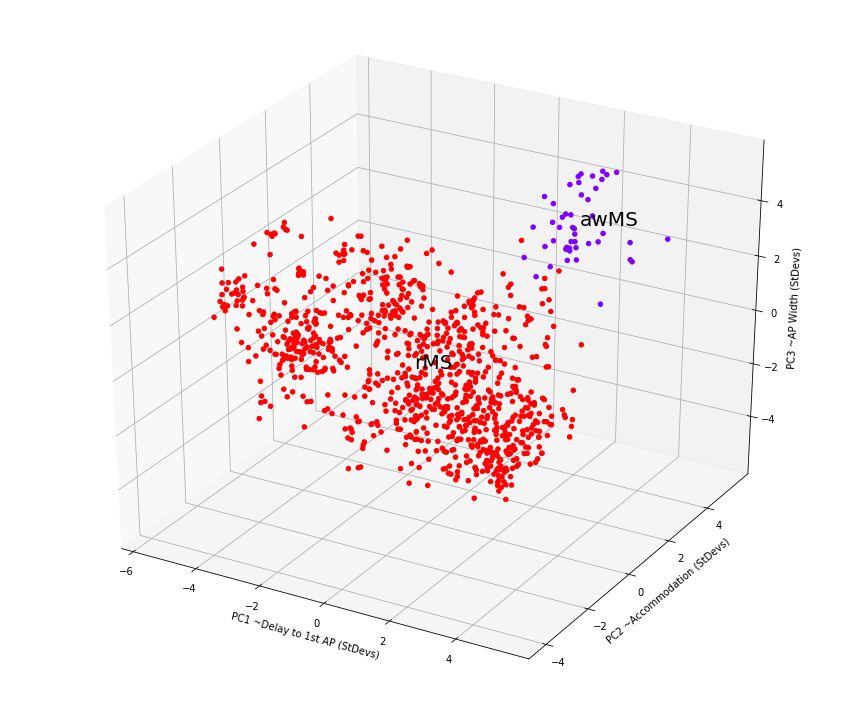

Number of members in each cluster assignment: Counter({1: 949, 0: 46, -1: 1})
{'cells': Index([u'NMLCL000670', u'NMLCL000644', u'NMLCL000643', u'NMLCL000681',
       u'NMLCL000678'],
      dtype='object', name=u'Cell_ID'),
 'center': ['        2.33', '        3.49', '        3.50'],
 'cluster': 0,
 'sd': ['        0.86', '        0.97', '        1.02']}
{'cells': Index([u'NMLCL000776', u'NMLCL000392', u'NMLCL000329', u'NMLCL000372',
       u'NMLCL000769'],
      dtype='object', name=u'Cell_ID'),
 'center': ['       -0.29', '       -0.24', '       -0.38'],
 'cluster': 1,
 'sd': ['        2.63', '        1.93', '        1.87']}
['ISIMedian', 'AccommodationAtSSMean', 'AP1DelayMeanStrongStim']
('reg isi v delay params p-s r', array([0.00174456, 0.20216814]), array([nan, nan]), nan)
('reg accom v delay params p-s r', array([ 0.00667163, -0.39531237]), array([nan, nan]), nan)
('delay v accom', (nan, nan))
('delay v isi', (nan, nan))
('reg isi v delay params p-s r', array([34.98174121, -0.052

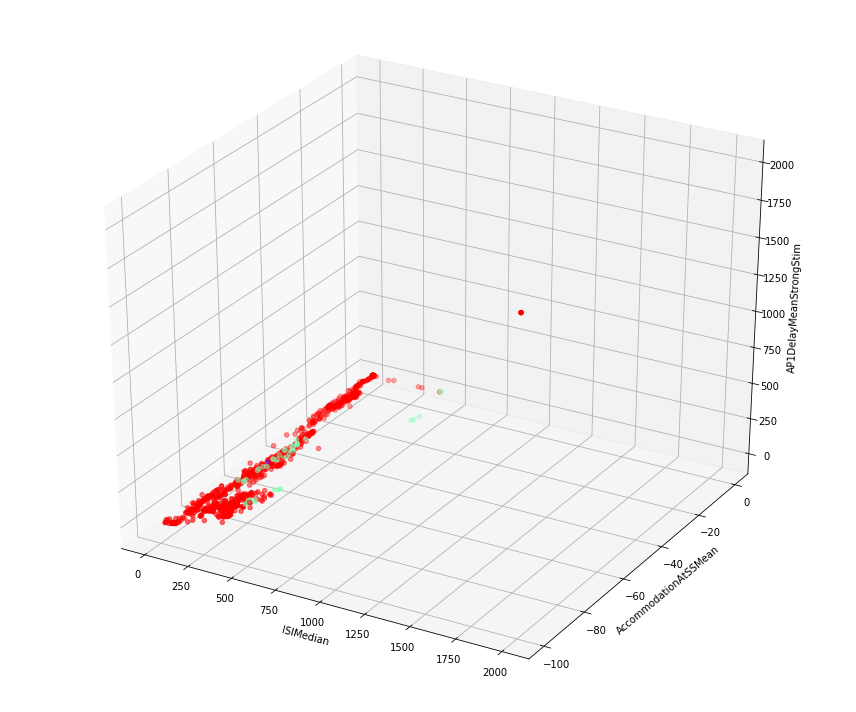

('current subset clusters', array(['/1/0/', '/1/1/'], dtype=object))
('all clusters', array(['/0/', '/1/0/', '/1/1/'], dtype=object))


In [18]:
# grab larger cluster
PCA_and_Cluster(samples_df = cortical_ephys_df,
                raw_samples_df = cortical_ephys_no_trans_df,
                parent_path = "/1/", 
                hide_noise = True, 
                remove_noise = True, 
                k_means = False, 
                interactive=False,
                cluster_captions=['awMS','rMS'],
                axis_captions=['PC1 ~Delay to 1st AP (StDevs)', 'PC2 ~Accommodation (StDevs)', 'PC3 ~AP Width (StDevs)'])

Dimensions reduced from 42 to 20
Number of rows = 1046


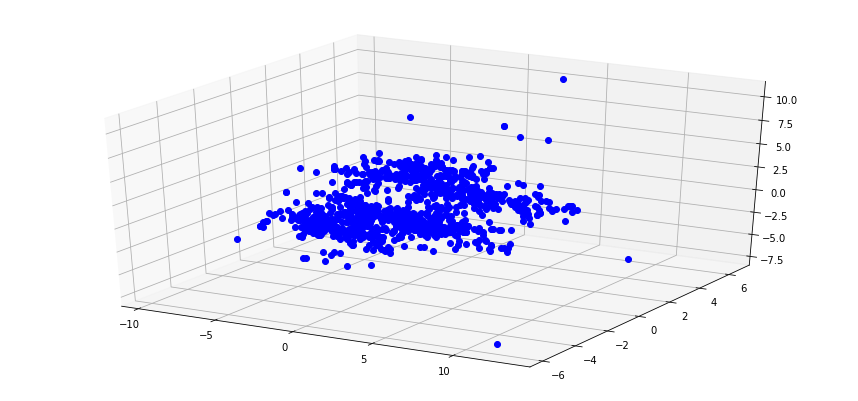

For n_clusters = 2, the average silhoette score is = 0.210741924164073
For n_clusters = 3, the average silhoette score is = 0.18880366680859773
For n_clusters = 4, the average silhoette score is = 0.19457810490588098
For n_clusters = 5, the average silhoette score is = 0.17620647448195143
For n_clusters = 6, the average silhoette score is = 0.18889121943750842
For n_clusters = 7, the average silhoette score is = 0.1956808071245259


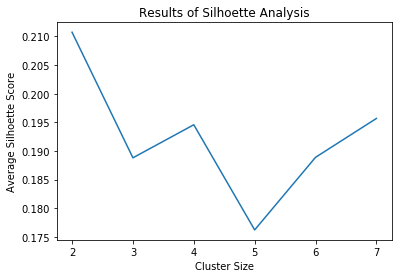

Positive vs Negative loadings with PC1 :
['AP2DelayMean' 'AP2DelayMeanStrongStim' 'AP1DelayMean'
 'AP1DelayMeanStrongStim' 'Burst1ISIMeanStrongStim']
[0.88913021 0.87882732 0.87850923 0.87483213 0.73878202]
+ R for AP2DelayMean
+ R for AP2DelayMeanStrongStim
+ R for AP1DelayMean

         -----            
Positive vs Negative loadings with PC2 :
['ISIMedian' 'SSAccommodationMean' 'InitialAccommodationMean' 'ISICV'
 'SpikeRateStrongStim']
[-0.77877065  0.73395047  0.72138219  0.71368832  0.70099595]
- R for ISIMedian
+ R for SSAccommodationMean
+ R for InitialAccommodationMean

         -----            
Positive vs Negative loadings with PC3 :
['AP2RateOfChangePeakToTrough' 'AccommodationAtSSMean'
 'AP1RateOfChangePeakToTrough' 'ISICV' 'AP2WidthPeakToTrough']
[-0.55411103  0.51272954 -0.50352288  0.46793673 -0.46307752]
- R for AP2RateOfChangePeakToTrough
+ R for AccommodationAtSSMean
- R for AP1RateOfChangePeakToTrough

         -----            


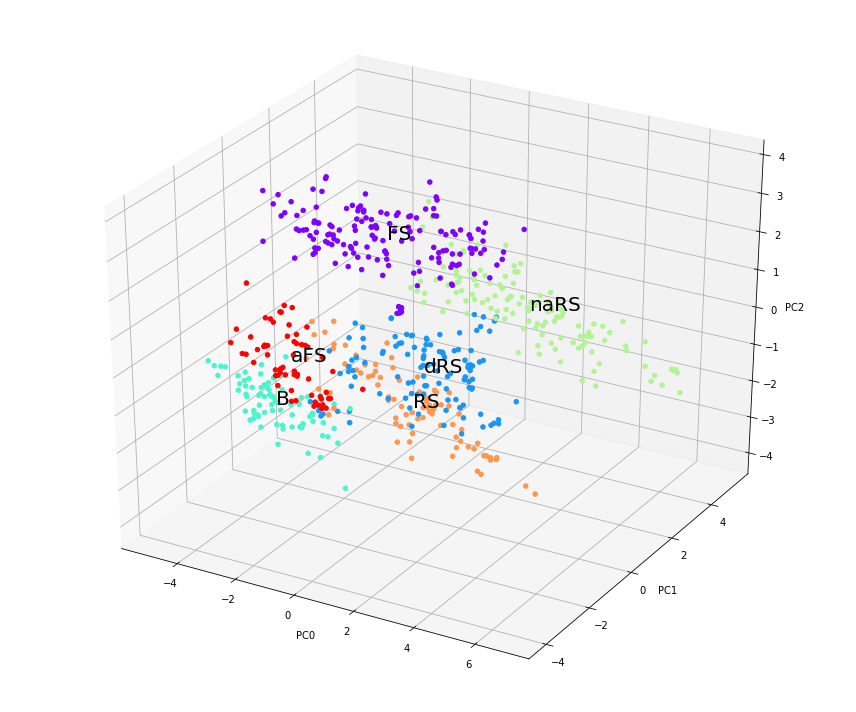

Number of members in each cluster assignment: Counter({0: 157, 3: 130, 1: 113, 4: 87, 2: 78, 5: 61})
{'cells': Index([u'NMLCL001025', u'NMLCL001044', u'NMLCL001043', u'NMLCL001061',
       u'NMLCL001024'],
      dtype='object', name=u'Cell_ID'),
 'center': ['       -2.21', '        2.32', '        1.44'],
 'cluster': 0,
 'sd': ['        1.56', '        1.53', '        0.98']}
{'cells': Index([u'NMLCL000468', u'NMLCL000616', u'NMLCL000580', u'NMLCL000626',
       u'NMLCL000527'],
      dtype='object', name=u'Cell_ID'),
 'center': ['        2.61', '       -2.43', '        0.82'],
 'cluster': 1,
 'sd': ['        1.14', '        0.75', '        0.82']}
{'cells': Index([u'NMLCL000203', u'NMLCL000238', u'NMLCL000196', u'NMLCL000205',
       u'NMLCL000227'],
      dtype='object', name=u'Cell_ID'),
 'center': ['       -2.52', '       -2.21', '       -1.12'],
 'cluster': 2,
 'sd': ['        1.25', '        0.68', '        0.73']}
{'cells': Index([u'NMLCL000881', u'NMLCL000829', u'NMLCL000793', 

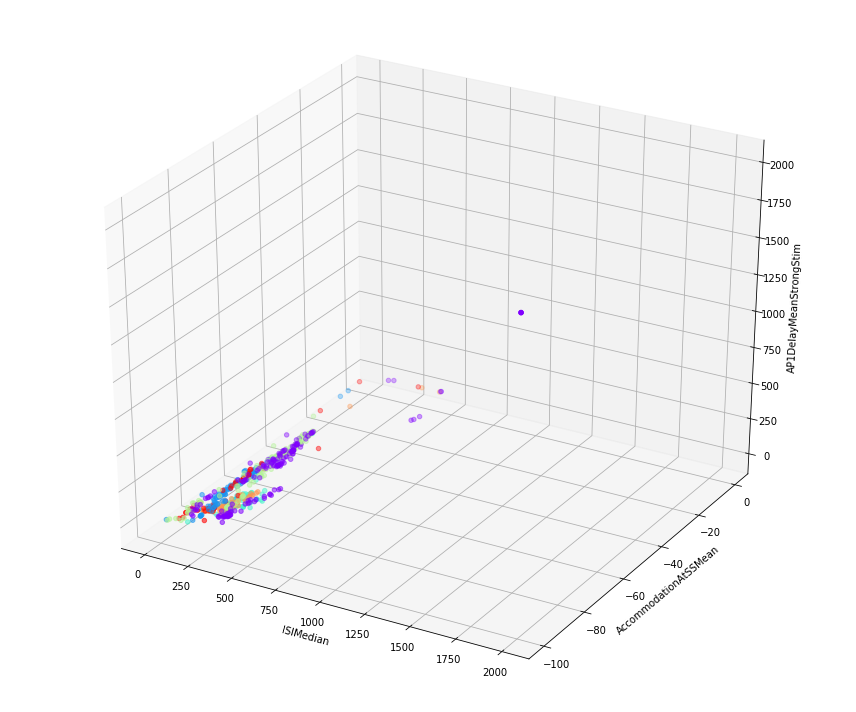

('reg isi v delay params p-s r', array([6.00304950e+00, 7.32986988e-05]), array([2.14195928e-05, 9.95138097e-01]), -0.016948507088518694)
('reg accom v delay params p-s r', array([12.62312678,  0.08668324]), array([5.30919135e-07, 3.54589614e-03]), 0.12060445819595922)
('delay v accom', (0.3677785346636752, 0.003545896135226598))
('delay v isi', (0.0007966782851338237, 0.9951380970466726))
Current subset clusters: ['/1/1/0/' '/1/1/1/' '/1/1/2/' '/1/1/3/' '/1/1/4/' '/1/1/5/']
All clusters : ['/0/' '/1/0/' '/1/1/0/' '/1/1/1/' '/1/1/2/' '/1/1/3/' '/1/1/4/' '/1/1/5/']


In [83]:
PCA_and_Cluster(samples_df = cortical_ephys_df,
                raw_samples_df = cortical_ephys_no_trans_df,
                parent_path = "/1/1/", 
                hide_noise = False, 
                remove_noise = True, 
                k_means = True, 
                interactive=False,
                cluster_captions=['FS','dRS','B','naRS','RS','aFS'])
#                 axis_captions=['PC1 ~Delay to 1st AP (StDevs)', 'PC2 ~Mean ISI (StDevs)', 'PC3 ~Accommodation (StDevs)'])

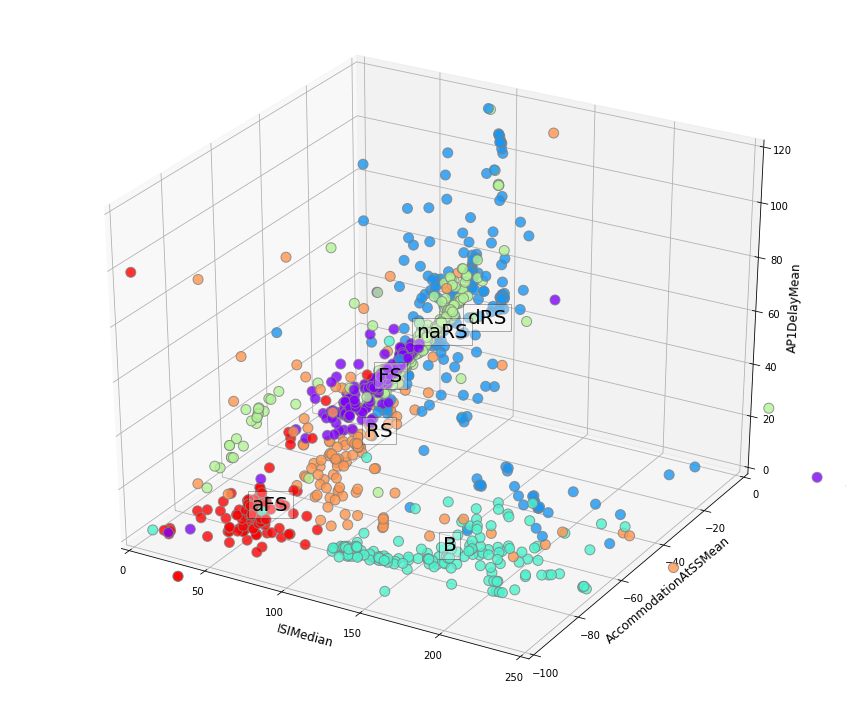

In [124]:
fig, ax = plot_ephys_clusters(samples_df=cortical_ephys_df,
                    raw_samples_df=cortical_ephys_no_trans_df,
                    display_props = ["ISIMedian","AccommodationAtSSMean","AP1DelayMean"],
                    x_lim=[0,250],y_lim=[-100,0],z_lim=[0,120]);


figname = join(path2figs,'cortical_clustering_v1.png')
plt.savefig(figname,dpi=150,
                bbox_inches='tight')



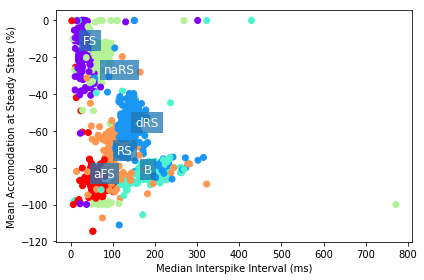

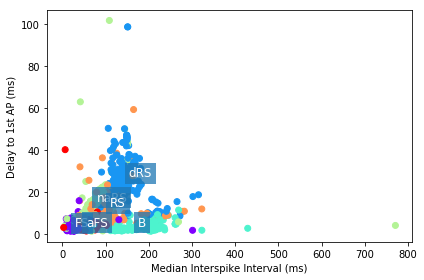

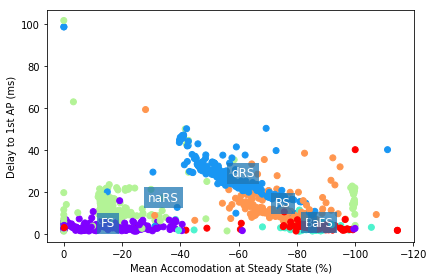

In [63]:
plot_tetrahedron_projection(0,1)
plot_tetrahedron_projection(0,2)
plot_tetrahedron_projection(1,2,True)



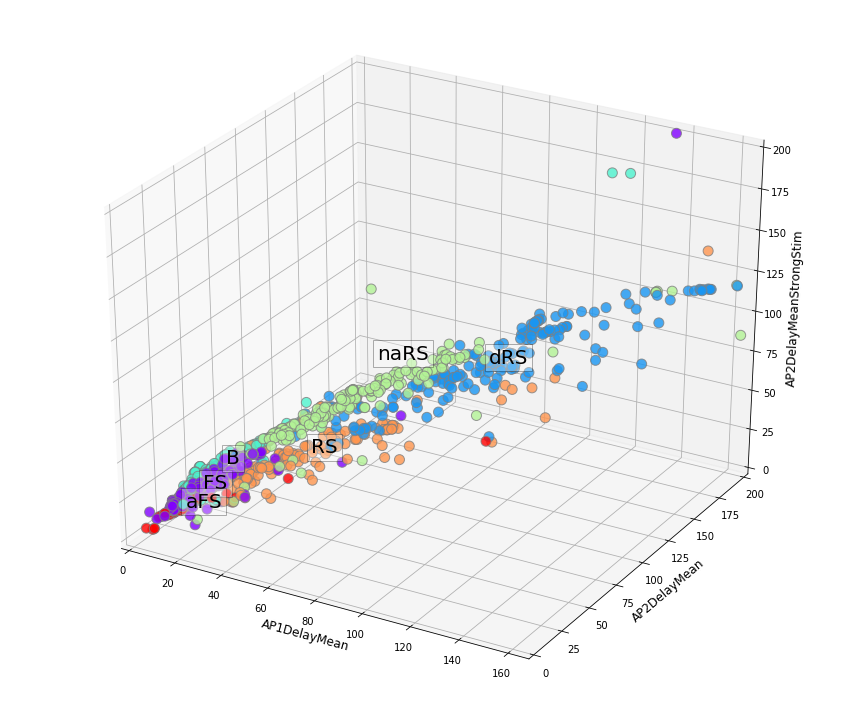

In [44]:
# Just properties with high loading with PC 1
plot_ephys_clusters(samples_df=cortical_ephys_df,
                    raw_samples_df=cortical_ephys_no_trans_df,
                    display_props = ['AP1DelayMean',"AP2DelayMean","AP2DelayMeanStrongStim"],
                    x_lim=[0,165],y_lim=[0,200],z_lim=[0,200]);



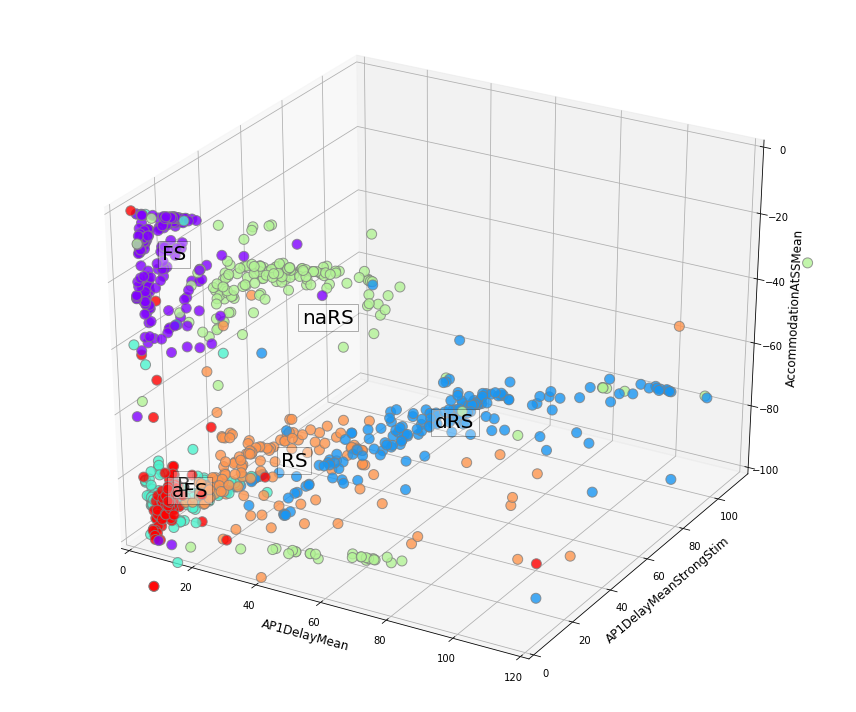

In [47]:
plot_ephys_clusters(samples_df=cortical_ephys_df,
                    raw_samples_df=cortical_ephys_no_trans_df,
                    display_props = ['AP1DelayMean',"AP1DelayMeanStrongStim","AccommodationAtSSMean"],
                    x_lim=[0,120],y_lim=[0,115],z_lim=[-100,0]);



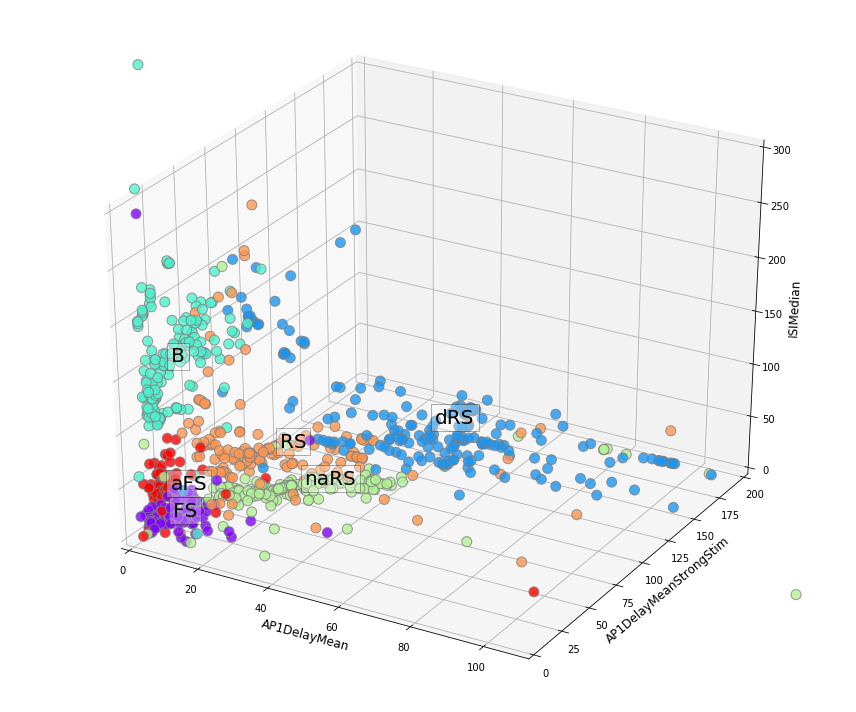

In [52]:
plot_ephys_clusters(samples_df=cortical_ephys_df,
                    raw_samples_df=cortical_ephys_no_trans_df,
                    display_props = ['AP1DelayMean',"AP1DelayMeanStrongStim","ISIMedian"],
                    x_lim=[0,110],y_lim=[0,200],z_lim=[0,300]);



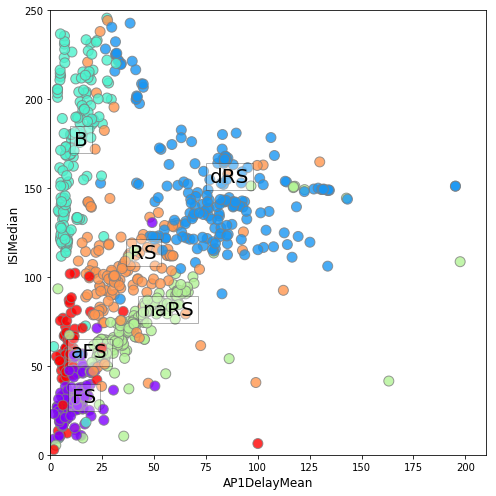

In [113]:
plot_ephys_clusters(samples_df=cortical_ephys_df,
                    raw_samples_df=cortical_ephys_no_trans_df,
                    display_props = ['AP1DelayMean',"ISIMedian"],
                    x_lim=[0,210],y_lim=[0,250],
                    figsize=(7,7),
                    plot_3d=False);


figname = join(path2figs,'cortical_clustering_v5.png')
plt.savefig(figname,dpi=150,
                bbox_inches='tight')

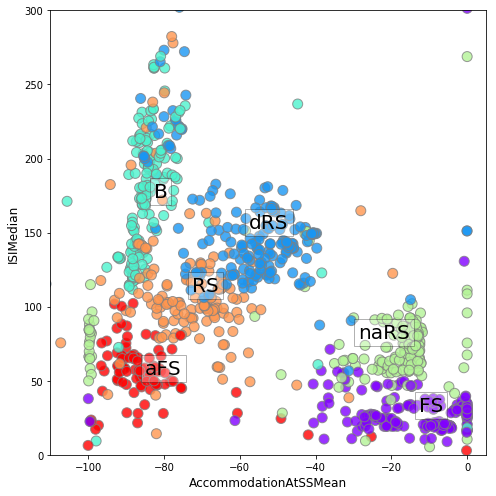

In [114]:
plot_ephys_clusters(samples_df=cortical_ephys_df,
                    raw_samples_df=cortical_ephys_no_trans_df,
                    display_props = ["AccommodationAtSSMean","ISIMedian"],
                    x_lim=[-110,5],y_lim=[0,300],
                    figsize=(7,7),
                    plot_3d=False);


figname = join(path2figs,'cortical_clustering_v6.png')
plt.savefig(figname,dpi=150,
                bbox_inches='tight')

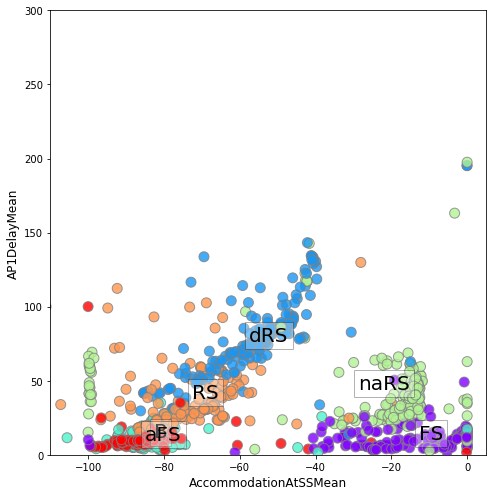

In [115]:
plot_ephys_clusters(samples_df=cortical_ephys_df,
                    raw_samples_df=cortical_ephys_no_trans_df,
                    display_props = ["AccommodationAtSSMean",'AP1DelayMean'],
                    x_lim=[-110,5],y_lim=[0,300],
                    figsize=(7,7),
                    plot_3d=False);


figname = join(path2figs,'cortical_clustering_v7.png')
plt.savefig(figname,dpi=150,
                bbox_inches='tight')

In [100]:
# save clustered samples
filename = join(path2data,'clustered_ephys_samples.csv')
cortical_ephys_df.to_csv(filename)

# save clustered raw samples
filename = join(path2data,'clustered_ephys_no_trans_samples.csv')
cortical_ephys_no_trans_df.to_csv(filename)

In [23]:
#CLUSTER naRS RELATIONSHIP EXAMPLES
#display_props = ["ISIMedian","AccommodationAtSSMean","AP1DelayMeanStrongStim"]

min_x = source_df.ix[np.where(clusters == 1)]["AccommodationAtSSMean"].min()
print(source_df[source_df["AccommodationAtSSMean"] == min_x]["AP1DelayMeanStrongStim"])

max_x = source_df.ix[np.where(clusters == 1)]["AccommodationAtSSMean"].max()
print(source_df[source_df["AccommodationAtSSMean"] == max_x]["AP1DelayMeanStrongStim"])



Series([], Name: AP1DelayMeanStrongStim, dtype: float64)
Series([], Name: AP1DelayMeanStrongStim, dtype: float64)


In [24]:
#CLUSTER dRS RELATIONSHIP EXAMPLES
#display_props = ["ISIMedian","AccommodationAtSSMean","AP1DelayMeanStrongStim"]

min_x = source_df.ix[np.where(clusters == 2)]["ISIMedian"].min()
print(source_df[source_df["ISIMedian"] == min_x]["AP1DelayMeanStrongStim"])

max_x = source_df.ix[np.where(clusters == 2)]["ISIMedian"].max()
print(source_df[source_df["ISIMedian"] == max_x]["AP1DelayMeanStrongStim"])



Series([], Name: AP1DelayMeanStrongStim, dtype: float64)
Series([], Name: AP1DelayMeanStrongStim, dtype: float64)


<hr>

# Could be put into a separate packages

In [101]:
def plot_ephys_clusters(samples_df,raw_samples_df,
                        display_props = ['AP1DelayMean','AP2DelayMean','AP2DelayMeanStrongStim'],
                        cluster_path = '/1/1/',
                        cluster_captions=['FS','dRS','B','naRS','RS','aFS'],
                        figsize = (12,10),x_lim=None,y_lim=None,z_lim=None,
                        plot_3d=True,save_fig=False,show_colorbar=False,
                        plot_channels=False,channel_type=None,cond_dens_df=None):
    '''
        Plots clustering results for desired properties. Used in poster.

    '''
    
    # get desired clusters
    source_df = samples_df[samples_df["ClusterPath"].str.startswith(cluster_path)]
    clusters = source_df["Cluster"]
    source_df = raw_samples_df.loc[source_df.index]
    
    desired_models = source_df.index.tolist()
    
    xs = source_df[display_props[0]]
    ys = source_df[display_props[1]]
    
    if len(display_props)>2:
        zs = source_df[display_props[2]]
        
    
    if plot_3d:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        
        if not plot_channels:
            cmap = 'rainbow'
            c = clusters
        else:
            print('Overlaying channel density...')
            cmap = 'viridis'
            reduced_cond_dens_df = cond_dens_df[cond_dens_df['Model_ID'].isin(desired_models)]
            cond_dens_vals = reduced_cond_dens_df[channel_type].values
            c = cond_dens_vals
            ax.set_title('Relative presence of %s Channels' %channel_type,y=1.04,size='x-large')
    
        
        sc = ax.scatter(
                xs, ys, zs, 
                depthshade=False,
                marker='o', 
                c=c,
                edgecolors='gray',
                cmap=cmap,
                s=100,
                alpha=0.8)
        
        # clean z-axis
        if not z_lim is None:
            ax.set_zlim(z_lim)
            
        ax.set_zlabel(display_props[2],size='large')
        
        
    else:
        fig, ax = plt.subplots(1,1,figsize=figsize)
        
        if not plot_channels:
            cmap = 'rainbow'
            c = clusters
        else:
            print('Overlaying channel density...')
            cmap = 'viridis'
            reduced_cond_dens_df = cond_dens_df[cond_dens_df['Model_ID'].isin(desired_models)]
            cond_dens_vals = reduced_cond_dens_df[channel_type].values
            c = cond_dens_vals
            ax.set_title('Relative presence of %s Channels' %channel_type,y=1.04,size='x-large')
        
        
        
        sc = ax.scatter(
                xs, ys,
                marker='o', 
                c=c,
                edgecolors='gray',
                cmap=cmap,
                s=100,
                alpha=0.8)

    
    # clean axes
    ax.set_xlabel(display_props[0],size='large')
    ax.set_ylabel(display_props[1],size='large')

    if not x_lim is None:
            ax.set_xlim(x_lim)
    if not y_lim is None:
            ax.set_ylim(y_lim)
            
    if plot_channels and show_colorbar:
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes('right', size="5%", pad=0.05)
#         fig.colorbar(sc,cax=cax)
#         plt.tight_layout(h_pad=1)
        fig.colorbar(sc,shrink=0.7)
        ax.set_aspect('auto')
        plt.tight_layout()
        
    else:
        plt.tight_layout()
            

    
    # add cluster assignment labels
    labels = np.unique(clusters)

    for i, l in enumerate(labels):
        X_label = source_df[clusters == l]
        center = [np.mean(X_label[prop]) for prop in display_props]
        if plot_3d:
            ax.text(center[0],center[1],center[2],cluster_captions[i],size=20, bbox=dict(facecolor='white', alpha=0.3))
        else:
            ax.text(center[0],center[1],cluster_captions[i],size=20, bbox=dict(facecolor='white', alpha=0.3))
    
        
     
    
    return fig, ax







In [11]:
def confirm_cortical_model(neurolex_term):
    '''
        Used to NeuroLex ID containing the brain area. 'cort' used for neocortex or other similar names.
        
        ----
        PARAMETERS : (str) describes cell model
        
    '''
    try:
        return 'cort' in neurolex_term
    except TypeError: # if neurolex_term is None, these should be manually validated
        return False
    
    

In [12]:
def get_neuron_model_details(nmldb_id):
    '''
        NeuroML-DB API query for model details
        
        TODO: Check if file is store already somewhere and load that instead of calling API.
        
        ----
        PARAMETER:
            - nmldb_id : (str) Contains NML ID 
            
        OUTPUT:
            - mldb_model_response : (str) Contains all model details in JSON format
    '''
    
    if nmldb_id in ['all']:
        nmldb_url = 'http://neuroml-db.org/api/models'
        
        nmldb_model_response = requests.get(nmldb_url)
    
    else:
        nmldb_url = 'http://neuroml-db.org/api/model?id='

        neuron_url = nmldb_url + nmldb_id

        nmldb_model_response = requests.get(neuron_url)
    
    return nmldb_model_response.json()



In [13]:
def get_list_of_all_cortical_models(tags_df):
    '''
        Takes the complete list of cell model ID in NeuroML-DB to:
            1. search for information about whether cell is a cortical cell model or not, 
            2. automatically create a list of those cortical cell models, and
            3. manually add any known missing cortical cell models.
        
        ----
        PARAMETERS:
            - tags_df : (pandas.DataFrame) Contains all NMLCLXXXXXX IDs
        
        OUTPUT:
            - cortical_tags_list : (list) Contains updated list of tags with NMLCLXXXXXX IDs
     
    '''
    
    
    models = tags_df['Model_ID'].values
    cortical_tags_list = []
    non_cortical_tags_list = []
    
    
    for nmldb_id in models:
        
        try:
        
            this_model_details = get_neuron_model_details(nmldb_id=nmldb_id)

        except:
            print('Requests ConnectionError for ID = %s' %nmldb_id)

            
        neurolex_details = this_model_details['neurolex_ids']

        # !-- TODO: Put the following into the confirm_cortical_cell
        # !-- TODO: Use KEYWORDS also to figure out if cortical
        keyword_details = this_model_details['keywords'] 
        
        model_details = [neurolex_details, keyword_details] # use this as input
        
        # if two neurolex IDs
        try:
            neurolex_type_1 = neurolex_details[0]['NeuroLex_Term']
            neurolex_type_2 = neurolex_details[1]['NeuroLex_Term']
            
        # if only one or zero neurolex IDs
        except IndexError:
            
            try:
                # if flag throws IndexError, then zero neurolex IDs
                neurolex_flag = neurolex_details[0]['NeuroLex_Term']
                    
                # these cells only have one neurolex ID
                neurolex_type_1 = neurolex_details[0]['NeuroLex_Term']
                neurolex_type_2 = None
                    
            except IndexError:
                
                neurolex_type_1 = None
                neurolex_type_2 = None
                
        # check if at least one neurolex ID contains infor suggesting that it is cortical
        if confirm_cortical_model(neurolex_type_1) or confirm_cortical_model(neurolex_type_2):
            
            cortical_tags_list.append(nmldb_id)
        else:
            
            # !-- NOTE: Manual cases to check for
            # In the case of the Gouwens "visual area" cells, grab these too, there's quite a few
            if 'visual area' in tags_df[tags_df['Model_ID']==nmldb_id]['Name'].iloc[0]:
                cortical_tags_list.append(nmldb_id)
                
            # Hard-coded cortical model NMLCLXXXXXX IDs missed
                
            else:
                # Case 1) show which ones don't have any info in Neurolex IDs to manually check OR
                # Case 2) show which ones have no info about being a cortical cell in their Neurolex IDs 
                print(tags_df[tags_df['Model_ID']==nmldb_id])
                non_cortical_tags_list.append(nmldb_id)

        
    
    return cortical_tags_list, non_cortical_tags_list
        
    

In [82]:
def PCA_and_Cluster(samples_df, raw_samples_df, parent_path = "/", hide_noise = False, remove_noise = False, cluster_all=False,
                    k_means = False, min_cluster_size = 10, kmeans_n_clusters = 6, target_var = .95,
                    cluster_captions=string.ascii_uppercase, axis_captions=['PC0','PC1','PC2'],
                    EDA_plot=True, interactive=False, verbose=True):

    '''
        Perform PCA, hierarchical clustering and silhoette analysis.

        !-- TODO: Remove technical notes.

        Technical notes:
        ----
            - Hierarchical clustering can either be top-down (kmeans) or bottom-up (density-based agglomerative). The bottom-up algorithm used
            is HDBSCAN, an algorithm that uses single-linkage method and produces clusters of varying densities based on cluster stability.
            Single-linkage was preferred as electrophysical properties form a continuum in feature space. It produces dendrograms with
            heterogeneous distance thresholds for each resulting cluster with min_cluster_size as the dominant constraint for cluster cutoffs.
            In addition, this algorithm results in a set of clusters that do not contain the total set of samples, i.e., the resulting clusters
            are not a partition of the feature space! Some samples remain unclustered resulting in a slimmer dendrogram and minimizing false
            positive assignment of members to clusters due to noise.

            - 


        ----
        PARAMETERS:
            - samples_df :
            - raw_samples_df :
            - parent_path : (str) Forms path from parent clusters to child clusters, ex: /0/2/1/ = cluster 0 -> child cluster 2 -> child cluster 1
            - hide_noise :
            - remove_noise :
            - cluster_all : (MIGHT BE THE SAME AS REMOVE NOISE)
            - k_means :
            - interactive :
            - min_cluster_size :
            - kmeans_n_clusters :
            - target_var :
            - cluster_captions :
            - axis_captions :
            - EDA_plot :
            - verbose :

        OUTPUT:
            - None

    '''

    # Subselect rows based on selected cluster
    df = samples_df[samples_df["ClusterPath"].str.startswith(parent_path)]

    # Normalize feature space
    ss = StandardScaler()

    try:
        x = ss.fit_transform(df.loc[:,prop_names].values)

    # Skip the below if no there are no samples in the cluster path
    except ValueError:
        print('Zero samples were found... skipping clustering')
        print(df) # sanity check

        return None


    # Begin PCA on ephys properties
    x = DataFrame(x,columns=prop_names)

    pca = PCA(svd_solver='full',n_components=target_var)

    principalComponents = pca.fit_transform(x)
    principalDf = DataFrame(data = principalComponents)

    X = principalDf.copy()
    X.index = df.index # Insert model IDs into PCA dataframe

    if verbose:
        print('Dimensions reduced from %s to %s' %(len(prop_names),len(principalDf.columns)))
        print('Number of rows = %s' %X.shape[0]) # sanity check


    # Exploratory cluster analysis of the PCA space - 3D plot, dendrogram, and silhouette analysis
    if EDA_plot:
        plt.figure(figsize=(15, 7))
        plt.axes(projection='3d')
        plt.plot(X[0],X[1], X[2],'bo')
        plt.show()


    # Define number of clusters to explore for silhoette analysis
    range_n_clusters = range(2, 8)

    clusters = []
    widths = []

    for n_clusters in range_n_clusters:
        #clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
        clusterer = KMeans(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        # compute average
        silhouette_avg = silhouette_score(X, cluster_labels)

        if verbose:
            print("For n_clusters = %s, the average silhoette score is = %s" %(n_clusters, silhouette_avg))

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        # store cluster sizes and their associated average silhoette score
        clusters.append(n_clusters)
        widths.append(silhouette_avg)



    if EDA_plot:
        plt.plot(clusters, widths)
        plt.xlabel('Cluster Size')
        plt.ylabel('Average Silhoette Score')
        plt.title('Results of Silhoette Analysis')
        plt.show()








    # Find the properties that are most highly correlated with the first 3 PCA components, i.e., positive loading
    pc_i=0
    comp_names = []

    for pc_i in range(3): # Only the first 3 PCs

        print('Positive vs Negative loadings with PC%s :' %(pc_i+1))

        # compute Pearson's correlation coefficient for pcs and properties
        prop_r = np.array([stats.pearsonr(X[pc_i],df[col])[0] if stats.pearsonr(X[pc_i],df[col])[1] < 0.001 else 0 for col in df.columns[:-3]]) # compute for every column in sample_df
        inds = (-np.abs(prop_r)).argsort() # greatest to least in absolute value


        # show the first five properties aranged in order of the sorted correlations
        print(np.array(prop_names)[inds][:5])
        print(prop_r[inds][:5])

#         if EDA_plot:
#             fig, ax = plt.subplots(1,1,figsize=(16,3))
#             ax.bar(range(10),prop_r[inds][:10])
#             ax.set_xticklabels(np.array(prop_names)[inds][:10],rotation=45)
#             ax.set_title('Principal Component %s Loading (Top 10)' %pc_i)
            
#             ax.set_xlabel('Ephyz features')
#             ax.set_ylabel("Pearson's coefficient")
            
#             plt.show()


        # show some of these results
        name = ""
        for f in range(3):
            name += ("- R for " if prop_r[inds][f] < 0 else "+ R for ") + prop_names[inds[f]] + '\n'
        comp_names.append(name)
        print(name)
        print("         -----            ")

        #     plt.plot(range(len(pca.components_[0])), pca.components_[i][inds])
   
        
        
        
    if interactive:
        %matplotlib notebook


    # 3D plot of clusters in PCA space
    X_w_noise = X.copy()
    X_w_noise["Cluster"] = -1
    X_w_noise["WasNoise"] = False

    
    # reperform density-based clustering without "noise" members
    if remove_noise:
        cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        cluster.fit_predict(X)
        X = X[cluster.labels_ != -1] # for visualization
    
    # perform feature space partitioning 
    if k_means:
        cluster = KMeans(n_clusters=kmeans_n_clusters,random_state=1)
        cluster.fit_predict(X)

    # default density-based clustering on all
    else:
        cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        cluster.fit_predict(X)

        
        
        
    if EDA_plot:
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')


        if hide_noise:
            ax.scatter(
                X[cluster.labels_ != -1][0],
                X[cluster.labels_ != -1][1],
                X[cluster.labels_ != -1][2], depthshade=False,marker='o',
                c=cluster.labels_[cluster.labels_ != -1],
                cmap='rainbow')

        else:
            ax.scatter(
                X[0],
                X[1],
                X[2], depthshade=False,marker='o',
                c=cluster.labels_,
                cmap='rainbow')

        ax.set_xlabel(axis_captions[0])
        ax.set_ylabel(axis_captions[1])
        ax.set_zlabel(axis_captions[2])


        centers = []

        if k_means:
            centers = cluster.cluster_centers_
        else:
            labels = np.unique(cluster.labels_) if not hide_noise else np.unique(cluster.labels_[cluster.labels_ != -1])

            for l in labels:
                X_label = X[cluster.labels_ == l]
                center = [np.mean(X_label[c]) for c in range(X.shape[1])]
                centers.append(center)

        pca_centers = centers

        # Show clusters as letters in the plot
        for i, center in enumerate(centers):
            ax.text(center[0],center[1],center[2],cluster_captions[i],size=20)

        plt.tight_layout()
        plt.show()
    
    
    
    
    

    for key in locals().keys():
        globals()[key] = locals()[key]

    print('Number of members in each cluster assignment: %s' %collections.Counter(cluster.labels_))

    # Print cluster summary stats
    for c, center in enumerate(centers):
        dist = np.apply_along_axis(euclidean, 1, X, center)
        dist_sort_is = dist.argsort()

        pp({"cluster": c,
            "cells": X.iloc[dist_sort_is].index[:5],
            "sd":["{:12.2f}".format(np.std(X.iloc[np.where(cluster.labels_ == c)][pc])) for pc in range(3)],
            "center":["{:12.2f}".format(c) for c in center[0:3]],
           })
        
        
        
        
        
        

    # 3D plot of clusters in RAW feature space
    source_df = raw_samples_df.loc[~X.index.duplicated(keep='first')] # just in case of accidental duplication   

    # predefined choice in ephys properties to show
    display_props = ["ISIMedian","AccommodationAtSSMean","AP1DelayMeanStrongStim"]

    
    if EDA_plot:
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(
            source_df[display_props[0]],
            source_df[display_props[1]],
            source_df[display_props[2]],
            depthshade=True,
            marker='o',
            c=cluster.labels_,
            cmap='rainbow')

        ax.set_xlabel(display_props[0])
        ax.set_ylabel(display_props[1])
        ax.set_zlabel(display_props[2])

        plt.tight_layout()

        centers = []
        sds = []

        labels = np.unique(cluster.labels_)

        print(display_props)

        for i, l in enumerate(labels):
            X_label = source_df[cluster.labels_ == l]
            center = [np.mean(X_label[prop]) for prop in display_props]
            centers.append(center)

            sd = [np.std(X_label[prop]) for prop in display_props]
            sds.append(sd)
            
#         ax.text(center[0],center[1],center[2],cluster_captions[i],size=20)
#         print(cluster_captions[i],["{:0.2f}+/-{:0.2f}".format(centers[i][c],sds[i][c]) for c,_ in enumerate(center)])
            
        plt.show()

        
        reg = smf.ols('AP1DelayMeanStrongStim~ISIMedian',data=X_label).fit()
        print('reg isi v delay params p-s r', reg._results.params, reg._results.pvalues, reg._results.rsquared_adj)

        reg = smf.ols('AP1DelayMeanStrongStim~AccommodationAtSSMean',data=X_label).fit()
        print('reg accom v delay params p-s r', reg._results.params, reg._results.pvalues, reg._results.rsquared_adj)

        print("delay v accom",stats.pearsonr(X_label["AP1DelayMeanStrongStim"],X_label["AccommodationAtSSMean"]))
        print("delay v isi",stats.pearsonr(X_label["AP1DelayMeanStrongStim"],X_label["ISIMedian"]))


        
    
    

    # Final dataframe updates
    X["Cluster"] = cluster.labels_ # Set cluster ids in the transformed DataFrame

    
    # Set cluster in the DF that also has any noise rows
    for label in X.index:
        X_w_noise.at[label, "Cluster"] = X.at[label, "Cluster"]

        
    # Assign noise models to the cluster with the closest center
    noise_models = X_w_noise[X_w_noise["Cluster"] == -1].index
    for model in noise_models:
        
        #find the closest pca space cluster center
        dist = np.apply_along_axis(euclidean, 1, pca_centers, X_w_noise.ix[model][:-2])
        dist_sort_is = dist.argsort()
        X_w_noise.at[model, "Cluster"] = dist_sort_is[0] #[0] stores the closest cluster ID
        X_w_noise.at[model, "WasNoise"] = True

        
    df["Cluster"] = X_w_noise["Cluster"]
    df["WasNoise"] = X_w_noise["WasNoise"]
    df["ClusterPath"] = parent_path + df["Cluster"].map(str) + "/"


    
    for label in df.index:
        samples_df.at[label, "ClusterPath"] = df.at[label, "ClusterPath"]
        samples_df.at[label, "Cluster"] = df.at[label, "Cluster"]
        samples_df.at[label, "WasNoise"] = df.at[label, "WasNoise"]
        

    # Shows tree structure in text for sanity check
    print('Current subset clusters: %s'%np.unique(df["ClusterPath"]))
    print('All clusters : %s'%np.unique(samples_df["ClusterPath"]))

    
    

In [16]:
def plot_tetrahedron_projection(dim_x = 1, dim_y = 2, invert_x=False):
    ax_labels = ["Median Interspike Interval (ms)", 
                 "Mean Accomodation at Steady State (%)", 
                 "Delay to 1st AP (ms)"]

    fig = plt.figure()#figsize=(12, 10))
    ax = fig.add_subplot(111)

    ax.scatter(
        source_df[display_props[dim_x]],
        source_df[display_props[dim_y]], 
        marker='o', 
        c=clusters, 
        cmap='rainbow')

    ax.set_xlabel(ax_labels[dim_x])
    ax.set_ylabel(ax_labels[dim_y])

    labels = np.unique(clusters)

    for i, l in enumerate(labels):
        X_label = source_df[clusters == l]
        center = [np.mean(X_label[prop]) for prop in display_props]
        ax.text(center[dim_x],center[dim_y],cluster_captions[i],size=12,backgroundcolor="#2E917A",color="w",bbox={'linewidth':0,'alpha':0.75})
        

    plt.tight_layout()

    if invert_x:
        plt.gca().invert_xaxis()

    plt.show() 